# Conditioning Examples to Guide The Evolutionary Search
Here, we explore time-dependent conditioning to sample high-fitness targets of a double-peak problem either from the first or third quadrant -- in an oscillatory fashion.

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from benchmark import run, configs
from analysis import load_benchmark
import utils

from foobench import Objective

## Use Objective Wrapper
- to minimize different `foo`s
- or `maximize` them.
- In the latter case, we may need to specify numerical limits to constraint the search-space

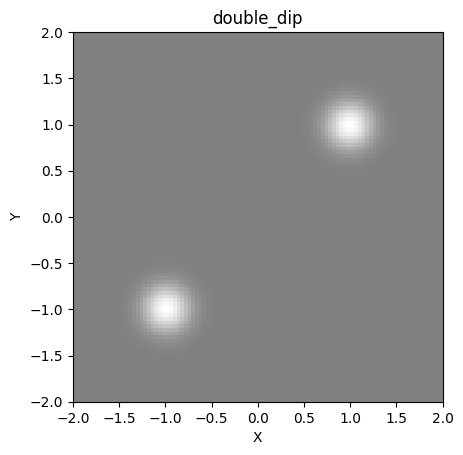

In [26]:
o = Objective(
    foo="double_dip",
    maximize=True,
    foo_kwargs={"m": 1.0}
)

from foobench.plot import visualize_2D
visualize_2D(o, parameter_range=2, vmin=-1, vmax=1, cmap="binary_r")

## Condition the DM to Sample Large Fitness Values with `CHARLES` (default)

In [27]:
DST_OSC = utils.DST + f"/paper_HADES/experiment_genecondition/target_osc"

## Time-Dependent Conditioning
- Sample a particular `target` condition for `period`-many generations, then go to next `target` element
-
### Implement `Condition` Class
- a condition should be derived from `hades.es.Condition`
- and implement the `evaluate` and `sample` methods:
    - The `evaluate` method maps a genotype, `x`, fitness `f`, or meta info from the `charles_instance`, to a numerical classifier that represents that particular condition/feature
    - The `sample` method is used by `hades.es.CHARLES` to provide condition values to sample the next offspring generation via the diffusion model, i.e., these are the classifier-free guidance values used for sampling new genotypes.
- Condition instances are passed in a tuple of conditions to the `hades.es.CHARLES` constructor.
- In the `benchmark.run` wrapper, we also apply JSON dumps for the `hades.es.CHARLES` kwargs, thus a `to_dict` method is implemented.

In [28]:
from condevo.es.guidance import Condition
from torch import Tensor, tensor, float32, ones

class OscillationQCondition(Condition):
    def __init__(self, target=[1, -1], period=8):
        Condition.__init__(self)
        self.target = np.array(target)
        self.period = period
        self._t = 0         # running counter for evaluation step
        self._target_i = 0  # running index for target

    def evaluate(self, charles_instance, x, f):
        dim = np.shape(x)[-1]
        g0 = x > 0
        rc = np.zeros(len(x))
    
        rc[g0[:,0] & g0[:,1]] = 1.
        rc[(~g0[:,0]) & (~g0[:,1])] = -1.
        if isinstance(x, Tensor):
            return tensor(rc, device=x.device, dtype=float32)
        return rc

    def get_target(self):
        i = self._target_i
        self._t += 1
        if not self._t % self.period:
            self._target_i = (self._target_i + 1) % len(self.target)
            self._t = 0
        
        return self.target[i]

    def sample(self, charles_instance, num_samples):
        # sample target quadrant, but oscillate target based on the internal counter
        return ones(num_samples, dtype=float32) * self.get_target()

    def to_dict(self):
        return {"target": self.target, "period": self.period, **Condition.to_dict(self)}


### Oscillatory condition sampling:

Text(0, 0.5, 'Target Condition')

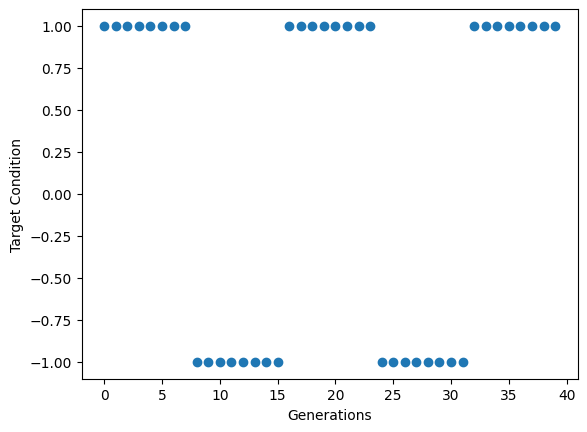

In [29]:
osc = OscillationQCondition()
condition = [osc.sample(None, 1).item() for t in range(40)]
plt.scatter(range(40), condition)
plt.xlabel("Generations")
plt.ylabel("Target Condition")

### Generate Data

In [30]:
EXECUTE_RUNS = False
if EXECUTE_RUNS:

    # Diffusion Model Config
    diff_config = {"num_steps": 1000, "alpha_schedule": "cosine_nichol"}

    # Evolutionary Solver config
    es_config = configs.CHARLES
    es_config["sigma_init"] = 2.0
    es_config["crossover_ratio"] = 0.125
    es_config["mutation_rate"] = 0.05
    es_config["unbiased_mutation_ratio"] = 1.0
    es_config["random_mutation_ratio"] = 0.0
    es_config["readaptation"] = False
    es_config["forget_best"] = True
    es_config["buffer_size"] = 3
    es_config["selection_pressure"] = 5
    es_config["is_genetic_algorithm"] = False
    es_config["diff_lr"] = 1e-2
    es_config["diff_max_epoch"] = 200
    es_config["training_interval"] = 1
    es_config["elite_ratio"] = 0.  # <-- we set the elite ratio to 0, to fully eliminate high-fitness residuals across generations

    # Number of independent experiments
    num_iter = 8

    rc_t = [run(objective=o,
            generations=40,
            diff="DDIM",
            diff_config=diff_config,
            nn="MLP",
            # use fitness conditioning:
            es="CHARLES",
            es_config={**es_config,
                       "conditions": (OscillationQCondition(),)  # provide condition(s) as tuple
                       },
            nn_config={"num_conditions": 1, **configs.MLP},
            dst=DST_OSC,
            )
            for _ in range(num_iter)
           ]

### Load Data
Data from HADES publication can be accessed [here](https://tufts.box.com/s/wnqs9levqm23zb4d6wo7hyi9etbodhjx),
follow provided extraction instructions.

In [31]:
df_osc = load_benchmark(objective="double_dip", es="CHARLES", dst=DST_OSC)

loading data from data/es_benchmark/optimize/paper_HADES/experiment_genecondition/target_osc/ES_CHARLES-objective_double_dip.h5
found runs: [0, 1, 2, 3, 4, 5, 6, 7]


### Analyze Data

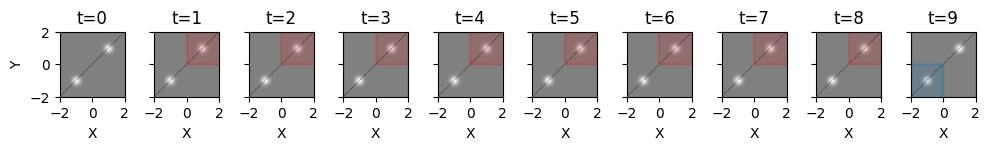

In [32]:
fig, axes = plt.subplots(1, 10, figsize=(10, 4), sharex=True, sharey=True)
for t, ax in enumerate(axes):
    visualize_2D(o, parameter_range=2, vmin=-1, vmax=1, ax=ax, title=f"t={t}", cmap="binary_r")
    ax.plot([-2, 2], [-2, 2], "k:", linewidth=0.5)

    if t > 0 and t < 9:
        ax.fill_between([0, 2], 0, 2, alpha=0.2, color="tab:red")
        ax.hlines([0], 0, 2, alpha=0.2, color="tab:red")
        ax.vlines([0], 0, 2, alpha=0.2, color="tab:red")

    elif t > 0:
        ax.fill_between([0, -2], 0, -2, alpha=0.2, color="tab:blue")
        ax.hlines([0], 0, -2, alpha=0.2, color="tab:blue")
        ax.vlines([0], 0, -2, alpha=0.2, color="tab:blue")

    if t > 0:
        ax.set_ylabel("")

plt.tight_layout()
fig.savefig("imgs/osc_double_peak_landscape.png", transparent=True, dpi=300)

In [33]:
def plot_dynamic(df):
    # Plot Fitness
    plt.figure(figsize=(12, 2))
    plt.plot(df["gen"], np.array([v for v in df["fitness"].values]).max(axis=-1), label="Population max.")
    plt.plot(df["gen"], np.array([v for v in df["fitness"].values]).mean(axis=-1), label="Population mean")
    plt.ylabel("Fitness")
    plt.xlabel("Generations")
    
    # Plot Parameters over Several Generations
    plt.figure()
    x = np.array([s for s in df["samples"]])
    
    n = 5
    nx, ny = int((df["gen"].max() + 1) // n), n
    fig, axes = plt.subplots(nx, ny, figsize=(12, 4 * nx), sharex=True, sharey=True)
    (_, range_x), (_, range_y), zz = o.eval_on_range(parameter_range=3)
    vmin = min([f.min() for f in df["fitness"]])
    vmax = min([f.max() for f in df["fitness"]])
    for gi, xi, ax in zip(df.sort_values("gen")["gen"][1:], df.sort_values("gen")["samples"][1:], axes.flatten()):
        im = ax.imshow(zz.T, extent=(*range_x, *reversed(range_y)))
        ax.invert_yaxis()
        
        sc = ax.scatter(*xi.T, s=5, edgecolors='red', c=None)
        ax.set_xlim(range_x)
        ax.set_ylim(range_y)
        ax.set_title(f"Generation {gi}")
    
    #plt.colorbar(im, ax=axes[-1])
    #plt.colorbar(sc, ax=axes[-1])
    plt.tight_layout(pad=0.01)


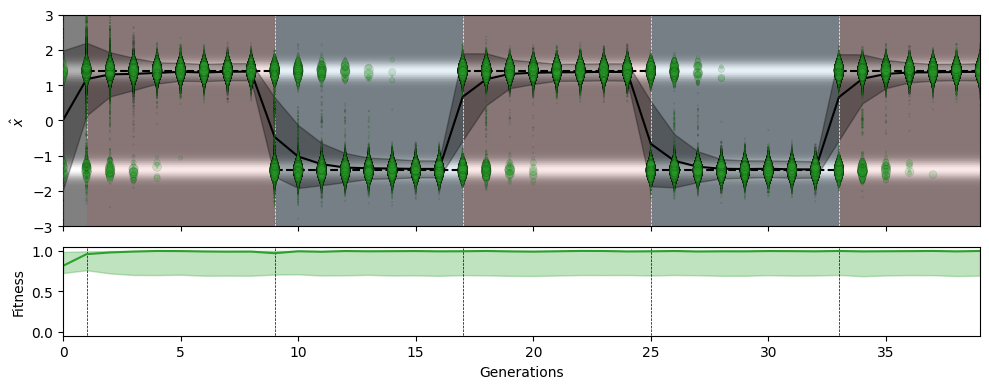

In [34]:
df = df_osc
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 4), sharex=True, gridspec_kw={"height_ratios": [2, 0.8]})

t = np.arange(df["gen"].max() + 1)
x = np.linspace(-3., 3., 101).reshape(-1, 1)
p = np.array((1., 1.))
p = p[:] / np.linalg.norm(p)

m = o.foo_kwargs["m"]
o.foo_kwargs["m"] = np.dot([1., 1.], p)
y = np.array([o(x).numpy() for ti in t])
o.foo_kwargs["m"] = 1.
ax1.imshow(y.T, vmin=-1, vmax=1, zorder=1, extent=((min(t)-0.5, max(t) + 1.5, min(x), max(x))), cmap="binary_r", aspect=1.5)
ax1.set_ylabel("$\\hat x$")
ax1.set_ylim((min(x), max(x)))

period = 8
for i in range(40 // period):
    target = np.array([-1, -1])**(i%2)
    ax1.hlines([target.dot(p)], xmin=i*period + 1, xmax=(i+1)*period + 1, color="black", linestyle="--", zorder=2)
    ax1.vlines([(i+1)*period + 1], ymin=-3, ymax=3, linestyle="--", color="white", linewidth=0.5, zorder=2)
    ax2.vlines([(i+1)*period + 1], ymin=-0.5, ymax=1.5, linestyle="--", color="black", linewidth=0.5, zorder=2)
    ax1.fill_between([i*period + 1, (i+1)*period + 1], -3, 3, color="tab:blue" if i%2 else "tab:red", alpha=0.1, zorder=1)
ax1.vlines([1], ymin=-0.5, ymax=1.5, linestyle="--", color="white", linewidth=0.5, zorder=2)
ax2.vlines([1], ymin=-0.5, ymax=1.5, linestyle="--", color="black", linewidth=0.5, zorder=2)


d_best = []
d_mu = []
d_std = []
d_fit = []    
d_gens = []
for r, df_r in df.groupby("run"):
    df_r = df_r.sort_values("gen")
    d_r = np.array([s.dot(p) for s in df_r["samples"]])    
    d_f = np.array([f for f in df_r["fitness"]])
    d_fbest = d_f.argmax(axis=1)
    d_best.append([d_ri[b] for d_ri, b in zip(d_r, d_fbest)])    
    g_r = np.array([[gi] * d_r.shape[1] for gi in df_r["gen"]])       
    d_mu.append(d_r.mean(axis=1))
    d_std.append(d_r.std(axis=1))
    d_fit.append(d_f)
    d_gens.append(g_r)

    ax1.scatter(g_r.flatten(), d_r.flatten(), s=50 * d_f.flatten() + 1, alpha=0.2, marker="o", edgecolors="black", linewidth=0.25, color="tab:green", zorder=3)
    

ax1.plot(g_r[:, 0], np.mean(d_mu, axis=0), color="black")    
ax1.fill_between(g_r[:, 0], np.mean(d_mu, axis=0) - np.mean(d_std, axis=0), np.mean(d_mu, axis=0) + np.mean(d_std, axis=0), color="black", alpha=0.3)    

max_best_fitness = np.max(np.max(d_fit, axis=-1), axis=0)
mean_best_fitness = np.mean(np.max(d_fit, axis=-1), axis=0)
std_best_fitness = np.mean(np.std(d_fit, axis=-1), axis=0)
ax2.plot(g_r[:, 0], np.mean(np.max(d_fit, axis=-1), axis=0), color="tab:green")
ax2.fill_between(g_r[:, 0], mean_best_fitness - std_best_fitness, max_best_fitness, color="tab:green", alpha=0.3)
ax2.set_ylim([-0.05, 1.05])
ax2.set_xlim([-0, 39])

ax2.set_ylabel("Fitness")
ax2.set_xlabel("Generations")
plt.tight_layout()
fig.savefig("imgs/osc_double_peak_samples.png", transparent=True, dpi=300)